In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Lectura de datos

In [2]:
X = pd.read_csv("X.csv")

X.head()

,id_annonce,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,...,nb_parking_places,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors
0,35996577,appartement,43.643880,7.117183,villeneuve-loubet,6270,63.0,NaN,NaN,NaN,...,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,35811033,appartement,45.695757,4.895610,venissieux,69200,90.0,3.0,NaN,223.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35731841,maison,47.966791,-1.220451,moutiers,35130,61.0,NaN,370.0,NaN,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35886765,maison,47.289292,-1.878805,cordemais,44360,142.0,NaN,764.0,217.0,...,0.0,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,35781137,appartement,45.718992,4.844234,lyon-7eme,69007,88.0,3.0,NaN,NaN,...,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
y = pd.read_csv("y.csv")

y.head()

,id_annonce,price
0,35996577,355000.0
1,35811033,190000.0
2,35731841,39000.0
3,35886765,299000.0
4,35781137,478000.0


In [4]:
data = X.merge(y, on='id_annonce')

## Selección de variables numéricas y cálculo de correlación

In [5]:
# Seleccionamos columnas numéricas
data_num = data[['approximate_latitude',
'approximate_longitude', 
'size', 
'floor', 
'land_size',
'energy_performance_value', 
'ghg_value', 
'nb_rooms', 
'nb_bedrooms', 
'nb_bathrooms', 
'nb_parking_places', 
'nb_boxes', 
'nb_photos',
'price']]

data_num.head()

,approximate_latitude,approximate_longitude,size,floor,land_size,energy_performance_value,ghg_value,nb_rooms,nb_bedrooms,nb_bathrooms,nb_parking_places,nb_boxes,nb_photos,price
0,43.643880,7.117183,63.0,NaN,NaN,NaN,NaN,3.0,2.0,NaN,0.0,0.0,4.0,355000.0
1,45.695757,4.895610,90.0,3.0,NaN,223.0,52.0,5.0,4.0,NaN,0.0,0.0,8.0,190000.0
2,47.966791,-1.220451,61.0,NaN,370.0,NaN,NaN,2.0,1.0,NaN,0.0,0.0,4.0,39000.0
3,47.289292,-1.878805,142.0,NaN,764.0,217.0,44.0,4.0,3.0,NaN,0.0,1.0,8.0,299000.0
4,45.718992,4.844234,88.0,3.0,NaN,NaN,NaN,4.0,3.0,1.0,0.0,1.0,5.0,478000.0


In [6]:
# Correlación de las columnas numéricas con la variable objetivo
corr_num_columns = abs(data_num.corr(method='pearson')['price'])
# Seleccionamos las columnas con correlación TOP 3
corr_num_columns = corr_num_columns.sort_values(ascending=False)[1:4].index.to_list()

corr_num_columns

['nb_rooms', 'nb_bedrooms', 'nb_bathrooms']

## Creación de sets de entrenamiento y testeo

In [7]:
# Separación de tests de entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(data_num[corr_num_columns].values, 
    data_num['price'].values.reshape(-1, 1), 
    test_size=0.2, 
    random_state=42,
    shuffle=True)

## Creación de pipelines para preprocesamiento de datos

In [8]:
# Pipeline para variables numéricas de la red neuronal
numerical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
])

# Pipeline para variables numéricas de la regresión polinomial
def make_numerical_polynomial_transformer(i):
    return Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('polynomial_features', PolynomialFeatures(degree=i, include_bias=False)),
            ('scaler', RobustScaler()),
    ])

## Modelo de redes neuronales para regresión

In [9]:
# Función para crear red neuronal
def generate_model(X_train, y_train, hidden_units, epochs, batch_size, learning_rate):
    # Early Stopping para evitar que entrene todas las epocas
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,       
        mode='min',
        restore_best_weights=True)
    callbacks_list = [early_stopping]
    # Crear red neuronal
    model = Sequential()
    model.add(InputLayer(shape=(X_train.shape[1],)))
    # Capas ocultas
    for i in hidden_units:
        model.add(Dense(i))
        # Función de activación LeakyReLU
        model.add(LeakyReLU())
        # Dropout para evitar sobreajuste
        model.add(Dropout(0.2))
    # Neurona de salida
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    model.fit(X_train, 
        y_train, 
        batch_size=batch_size, 
        epochs=epochs,
        validation_split=0.2,
        verbose=0,
        callbacks=callbacks_list)
    return model

## Funciones para entrenamiento de regresiones

In [10]:
# Función para entrenar y evaluar el modelo de red neuronal
def nn_training(X_train, X_test, y_train, y_test, hidden_units_list, epochs=5000, batch_size=64, learning_rate=1e-3, transformer=numerical_transformer):
    results = []
    X_train = transformer.fit_transform(X_train)
    X_test = transformer.transform(X_test)
    for hidden_units in hidden_units_list:
        model = generate_model(X_train, y_train, hidden_units, epochs, batch_size, learning_rate)
        y_pred = model.predict(X_test)
        # Calcular la raíz del error cuadrático medio (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"Hidden units: {hidden_units}. RMSE: {rmse:.2f}")
        results.append((model.count_params(), float(rmse)))
    return results

In [11]:
# Función para entrenar un modelo polinomial con regresión lineal
def polynomial_training(X_train, X_test, y_train, y_test, limit, columns=corr_num_columns):
    results = []
    for i in range(1, limit+1):
        transformer = make_numerical_polynomial_transformer(i)
        X_train_poly = transformer.fit_transform(X_train)
        X_test_poly = transformer.transform(X_test)
        linear_model = LinearRegression()
        linear_model.fit(X_train_poly, y_train)
        y_pred = linear_model.predict(X_test_poly)
        # Calcular la raíz del error cuadrático medio (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"Degree: {i}. RMSE: {rmse:.2f}")
        results.append((X_train_poly.shape[1]+1, float(rmse)))
    return results

In [12]:
# Entrenamiento de redes neuronales cada vez mas complejas
data_nn = nn_training(X_train, 
    X_test, 
    y_train, 
    y_test, 
    hidden_units_list=[[4,2], [8,4,2], [32,16,8,4], [64,32,16,8,4], [128,64,32,16,8,4]])

234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
Hidden units: [4, 2]. RMSE: 296558.64
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
Hidden units: [8, 4, 2]. RMSE: 297974.97
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
Hidden units: [32, 16, 8, 4]. RMSE: 293798.58
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
Hidden units: [64, 32, 16, 8, 4]. RMSE: 293547.53
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
Hidden units: [128, 64, 32, 16, 8, 4]. RMSE: 291289.29


In [13]:
for i in data_nn:
    print(f"Parameters: {i[0]}. RMSE: {i[1]:.2f}")

Parameters: 29. RMSE: 296558.64
Parameters: 81. RMSE: 297974.97
Parameters: 833. RMSE: 293798.58
Parameters: 3041. RMSE: 293547.53
Parameters: 11553. RMSE: 291289.29


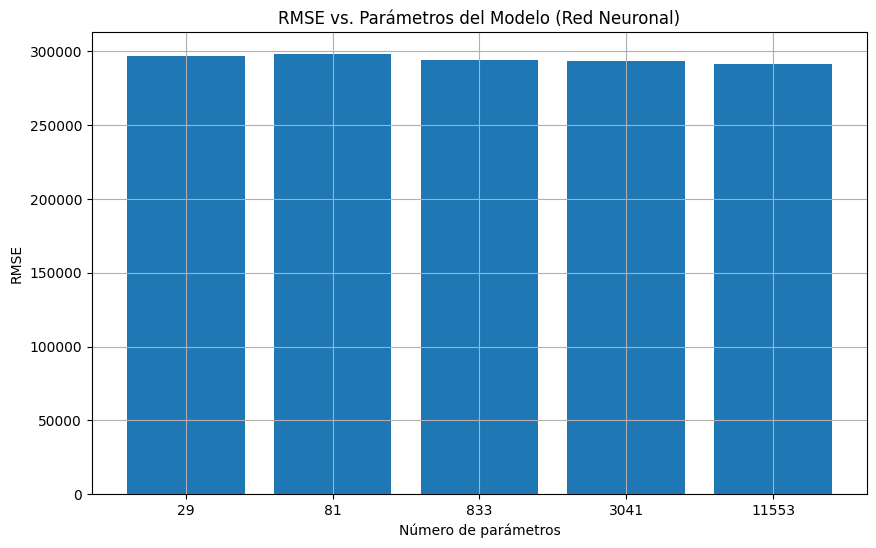

In [14]:
parameters = [str(i[0]) for i in data_nn]
rmse = [i[1] for i in data_nn]
plt.figure(figsize=(10, 6))
plt.bar(parameters, rmse)
plt.title('RMSE vs. Parámetros del Modelo (Red Neuronal)')
plt.xlabel('Número de parámetros')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

In [15]:
# Entrenamiento de regresiones polinómicas con cada vez más grado
data_poly = polynomial_training(X_train, 
    X_test, 
    y_train, 
    y_test, 
    10)

Degree: 1. RMSE: 293018.77
Degree: 2. RMSE: 304239.87
Degree: 3. RMSE: 288945.46
Degree: 4. RMSE: 1122811.06
Degree: 5. RMSE: 2299477.73
Degree: 6. RMSE: 9617983.06
Degree: 7. RMSE: 210750211.17
Degree: 8. RMSE: 4390251596.49
Degree: 9. RMSE: 2310199757.72
Degree: 10. RMSE: 274049989069.84


In [16]:
for i in data_poly:
    print(f"Parameters: {i[0]}. RMSE: {i[1]:.2f}")

Parameters: 4. RMSE: 293018.77
Parameters: 10. RMSE: 304239.87
Parameters: 20. RMSE: 288945.46
Parameters: 35. RMSE: 1122811.06
Parameters: 56. RMSE: 2299477.73
Parameters: 84. RMSE: 9617983.06
Parameters: 120. RMSE: 210750211.17
Parameters: 165. RMSE: 4390251596.49
Parameters: 220. RMSE: 2310199757.72
Parameters: 286. RMSE: 274049989069.84


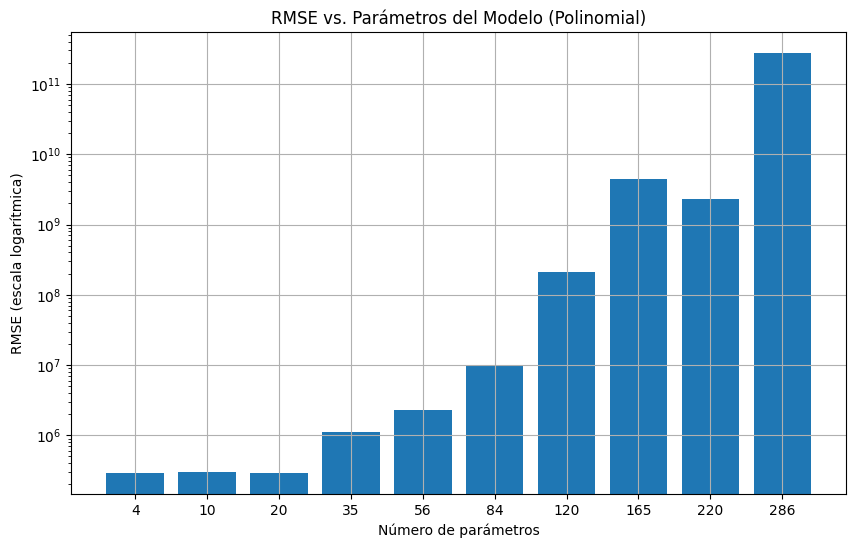

In [17]:
parameters = [str(i[0]) for i in data_poly]
rmse = [i[1] for i in data_poly]
plt.figure(figsize=(10, 6))
plt.bar(parameters, rmse)
plt.yscale('log')
plt.title('RMSE vs. Parámetros del Modelo (Polinomial)')
plt.xlabel('Número de parámetros')
plt.ylabel('RMSE (escala logarítmica)')
plt.grid(True)
plt.show()

Mientras que la regresión polinomial muestra un claro sobreajuste cuando aumentamos el grado del polinomio, que en este caso es a partir de grado 3, la red neuronal muestra un claro subajuste, ya que aunque se aumente el número de capas ocultas y el número de neuronas por capa, el error de validación se mantiene constante.
Puede deberse principalmente a que la red neuronal no está siendo capaz de aprender la relación entre las variables de entrada y la variable de salida.